In [1]:
import ast
import matplotlib.pyplot as plt
import multirecording_spikeanalysis_edit as spike
import numpy as np
import os
import pandas as pd
import pickle
# import spikeanal as spike
from pathlib import Path

cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp', 'competition_closeness']

comp_closeness_dict = {'Subj 1 blocking Subj 2': "competitive",
'Subj 2 Only': "no_comp",
'Subj 2 blocking Subj 1': "competitive",
'Subj 1 then Subj 2': "competitive", 
'Subj 1 Only': "no_comp",
'Subj 2 then Subj 1': "competitive",
'Close Call': "competitive",
'After trial': "no_comp"}

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']
    compness = row['competition_closeness']
    comp_label = comp_closeness_dict.get(compness, "")  # Default to "" if not found

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"

        # Determine the new condition based on competition and win/lose logic
        if condition in ['rewarded', 'omission', 'both_rewarded', 'tie']:
            new_condition = condition
        else:
            win_or_lose = 'win' if str(condition) == str(subject) else 'lose'
            new_condition = f"{comp_label}_{win_or_lose}"

        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': new_condition,
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
valid_conditions = ['rewarded', 'omission', 'both_rewarded', 'tie', 'no_comp_win', 'no_comp_lose', 'competitive_win', 'competitive_lose']
timestamp_dicts = {}

for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in valid_conditions}
    if condition in valid_conditions:
        timestamp_dicts[key][condition].append(tuple_val)
    else:
        print(f"Unexpected condition: {condition} for subj_recording {key}")

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [2]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'recordings' / 'from_cyborg'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec
<class 'numpy.ndarray'>
20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec


In [3]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [4]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

In [5]:
# Assuming event_and_pre_event_spikes_df is already loaded
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,0.0,4.0,4.0,4.0,4.0,4.0,0.0,...,4.0,0.0,4.0,12.0,8.0,4.0,8.0,0.0,0.0,8.0
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,8.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.0,0.0,12.0,4.0,4.0,8.0,12.0,...,4.0,4.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.0,10.0,14.0,6.0,8.0,10.0,10.0,...,6.0,10.0,8.0,10.0,6.0,6.0,16.0,12.0,10.0,4.0
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,4.0,6.0,10.0,14.0,24.0,12.0,6.0,...,2.0,2.0,4.0,0.0,2.0,10.0,12.0,4.0,8.0,18.0
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.0,0.0,4.0,8.0,2.0,4.0,10.0,...,4.0,0.0,2.0,0.0,2.0,4.0,8.0,4.0,10.0,8.0
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,4.0,6.0,4.0,2.0,2.0,6.0,4.0,2.0


In [6]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434
...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359


In [7]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 1.65),
    (event_zscores_df['Event Z-Score'] < -1.65)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig
...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase


In [8]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,5,0.00,0.000000,0.20,inf,increase,pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,10,0.30,1.066987,0.50,0.187444,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,13,4.10,4.482444,4.80,0.156165,not sig,interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,17,0.10,0.632456,0.60,0.790569,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,competitive_lose,19,4.70,3.936678,3.10,-0.406434,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
1741,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,49,8.15,3.400980,8.35,0.058807,not sig,pyramidal
1742,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,54,6.00,5.528481,3.35,-0.479336,not sig,pyramidal
1743,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,68,4.00,3.004270,3.35,-0.216359,not sig,pyramidal
1744,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,75,0.10,0.441443,1.30,2.718359,increase,pyramidal


In [9]:
sig_units = merged_df[merged_df['sig'] != 'not sig']

In [10]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]"
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[competitive_lose, competitive_win, no_comp_lo..."
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[competitive_lose, competitive_win, no_comp_lo..."
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[competitive_lose, competitive_win, no_comp_lo..."
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[competitive_lose, competitive_win, no_comp_lo..."
...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[competitive_lose, competitive_win, no_comp_lo..."
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[competitive_lose, competitive_win, no_comp_lo..."
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[competitive_lose, competitive_win, no_comp_lo..."
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,"[competitive_lose, tie]","[competitive_win, no_comp_lose, no_comp_win]"


In [11]:
units_df['Recording'].unique()

array(['20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec',
       '20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged.rec',
       '20230612_112630_standard_comp_to_training_D1_subj_1-2_t2b2L_box1_merged.rec',
       '20230613_105657_standard_comp_to_training_D2_subj_1-1_t1b2L_box1_merged.rec',
       '20230613_105657_standard_comp_to_training_D2_subj_1-4_t4b3L_box2_merged.rec',
       '20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.rec',
       '20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.rec',
       '20230616_111904_standard_comp_to_training_D4_subj_1-2_t2b2L_box2_merged.rec',
       '20230616_111904_standard_comp_to_training_D4_subj_1-4_t4b3L_box1_merged.rec',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec',
       '20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec',
       '20230618_100636_standard_comp_to_omission_D2_s

In [12]:
units_df['Recording'].nunique()

34

In [13]:
# Filter the units_df to include only rows where 'sig events' is not an empty list
sig_units2 = units_df[units_df['sig events'].apply(lambda x: len(x) > 0)].copy()

In [14]:
event_types = ['competitive_win', 'competitive_lose', 'no_comp_win', 'no_comp_lose']

In [18]:
sig_units2.to_excel("sig_units.xlsx")

In [19]:
sig_units2

,Recording,Unit number,sig events,not sig events
0,20230612_101430_standard_comp_to_training_D1_s...,5,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]"
5,20230612_101430_standard_comp_to_training_D1_s...,24,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]"
11,20230612_101430_standard_comp_to_training_D1_s...,53,[no_comp_win],"[competitive_lose, competitive_win, no_comp_lose]"
12,20230612_101430_standard_comp_to_training_D1_s...,54,[competitive_win],"[competitive_lose, no_comp_lose, no_comp_win]"
14,20230612_101430_standard_comp_to_training_D1_s...,58,[competitive_lose],"[competitive_win, no_comp_lose, no_comp_win]"
...,...,...,...,...
487,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,4,"[competitive_win, no_comp_lose]","[competitive_lose, no_comp_win, tie]"
488,20240323_144517_alone_comp_subj_3-4_t6b6_merge...,7,[no_comp_lose],"[competitive_lose, competitive_win, no_comp_wi..."
491,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,0,[tie],"[competitive_lose, competitive_win, no_comp_lo..."
494,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,24,"[no_comp_win, tie]","[competitive_lose, competitive_win, no_comp_lose]"


In [23]:
sig_units_single = sig_units2[~sig_units2['sig events'].astype(str).str.contains(',')].copy()
sig_units_single.to_excel("sig_units_single.xlsx")

In [25]:
sig_multiunits = sig_units2[sig_units2['sig events'].astype(str).str.contains(',')].copy()
sig_multiunits.to_excel("sig_units_multi.xlsx")

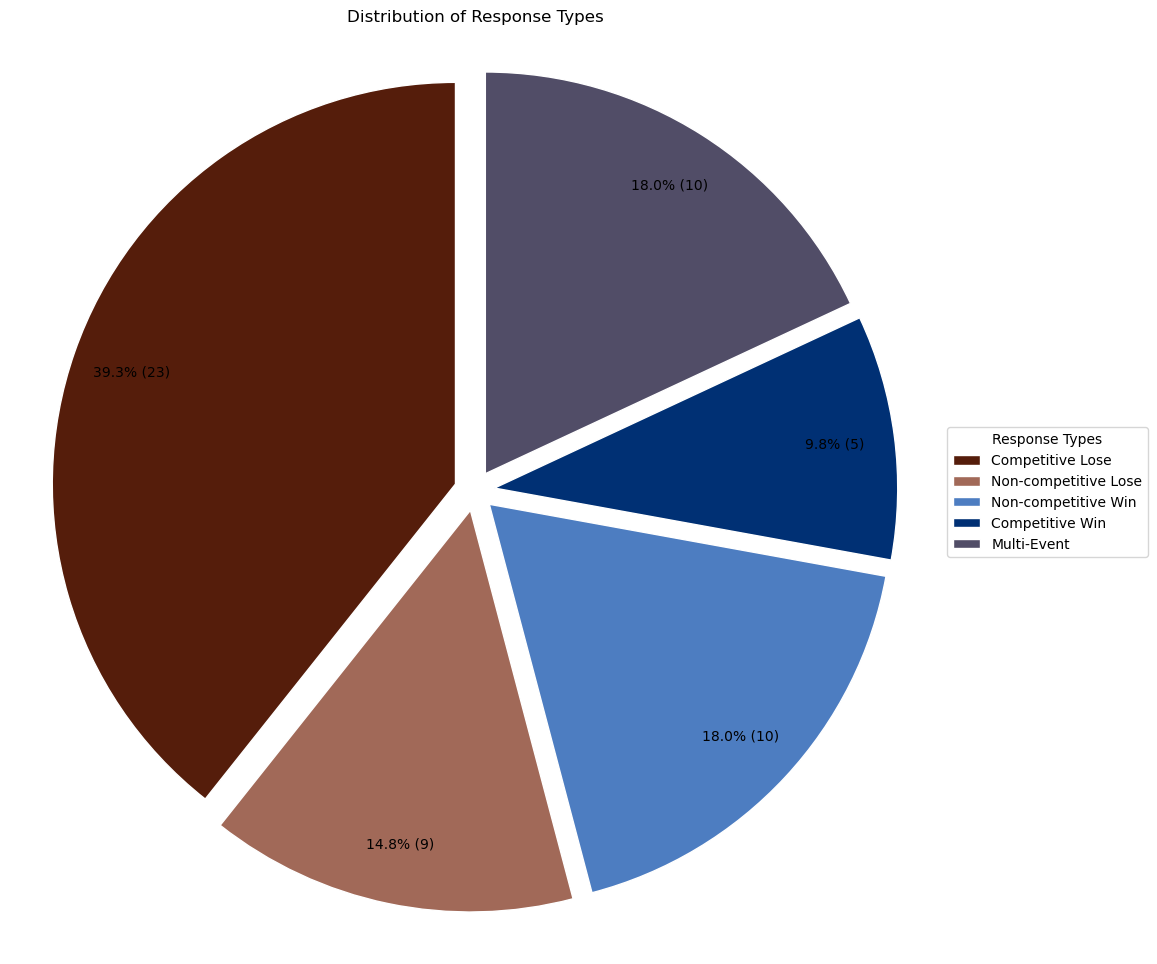

In [30]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Data for the pie chart (using your provided numbers)
events_count = {
    '[competitive_lose]': 24,
    '[competitive_win]': 6,
    '[no_comp_lose]': 9,
    '[no_comp_win]': 11,
    'Multi-Event': 11  # This combines all the multi-event counts
}

# Categories and their colors (matching the original pyramidal pie chart)
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b'},
    'Non-competitive Lose': {'count': events_count['[no_comp_lose]'], 'color': '#a16958'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1'},
    'Competitive Win': {'count': events_count['[competitive_win]'], 'color': '#003074'},
    'Multi-Event': {'count': events_count['Multi-Event'], 'color': '#514D67'}
}

# Prepare data for the pie plot
labels = list(categories.keys())
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Option to explode slices slightly for better visibility
explode = (0.05, 0.05, 0.05, 0.05, 0.05)  # slight explosion for each slice

# Create pie plot
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figure size as needed
wedges, texts, autotexts = ax.pie(sizes, colors=colors, startangle=90, explode=explode,
                                  autopct=lambda pct: "{:.1f}% ({:d})".format(pct, int(pct/100.*np.sum(sizes))),
                                  pctdistance=0.85, wedgeprops={'edgecolor': 'white', 'linewidth': 1})

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (you can adjust this as needed)
plt.title('Distribution of Response Types')  

# Adding a legend
ax.legend(wedges, labels,
          title="Response Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Check if the directory exists, and if not, create it
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save plot as SVG and JPG (you might want to change the filenames)
plt.savefig(f'{directory}/response_types_pie_chart.svg', format='svg', bbox_inches='tight') 
plt.savefig(f'{directory}/response_types_pie_chart.jpg', format='jpg', bbox_inches='tight') 

# Show plot
plt.show()

C:\Users\CShort\AppData\Local\Temp\ipykernel_75712\464452709.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()  # Remove legend


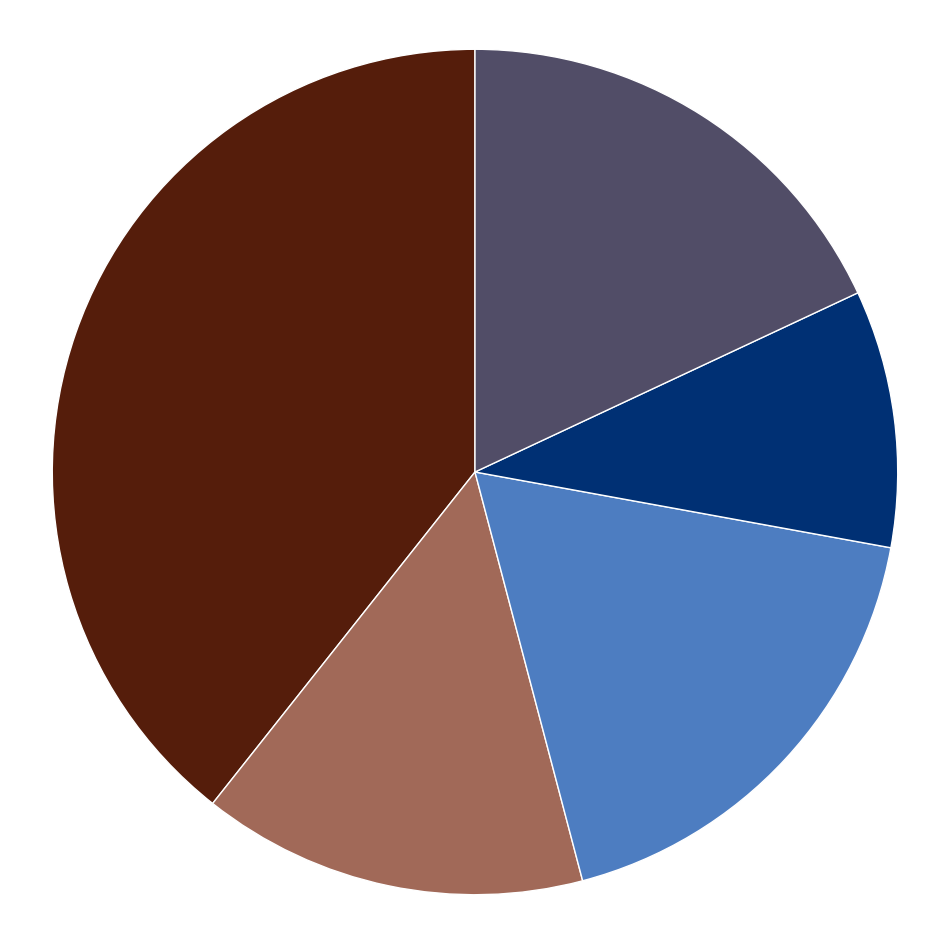

In [32]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Data for the pie chart
events_count = {
    '[competitive_lose]': 24,
    '[competitive_win]': 6,
    '[no_comp_lose]': 9,
    '[no_comp_win]': 11,
    'Multi-Event': 11 
}

# Categories and their colors
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b'},
    'Non-competitive Lose': {'count': events_count['[no_comp_lose]'], 'color': '#a16958'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1'},
    'Competitive Win': {'count': events_count['[competitive_win]'], 'color': '#003074'},
    'Multi-Event': {'count': events_count['Multi-Event'], 'color': '#514D67'}
}

# Prepare data for the pie plot
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Create pie plot
fig, ax = plt.subplots(figsize=(12, 12)) 
wedges, texts = ax.pie(sizes, colors=colors, startangle=90,  # Removed autotexts from assignment
                                  wedgeprops={'edgecolor': 'white', 'linewidth': 1})

ax.axis('equal')

# Remove all text elements
ax.set_title("")  # Remove title
for text in texts:
    text.set_visible(False)
for autotext in autotexts:
    autotext.set_visible(False)
ax.legend().remove()  # Remove legend

# Check if the directory exists, and if not, create it
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save plot as SVG and JPG
plt.savefig(f'{directory}/response_types_pie_chart_no_text.svg', format='svg', bbox_inches='tight') 
plt.savefig(f'{directory}/response_types_pie_chart_no_text.jpg', format='jpg', bbox_inches='tight') 

# Show plot
plt.show()

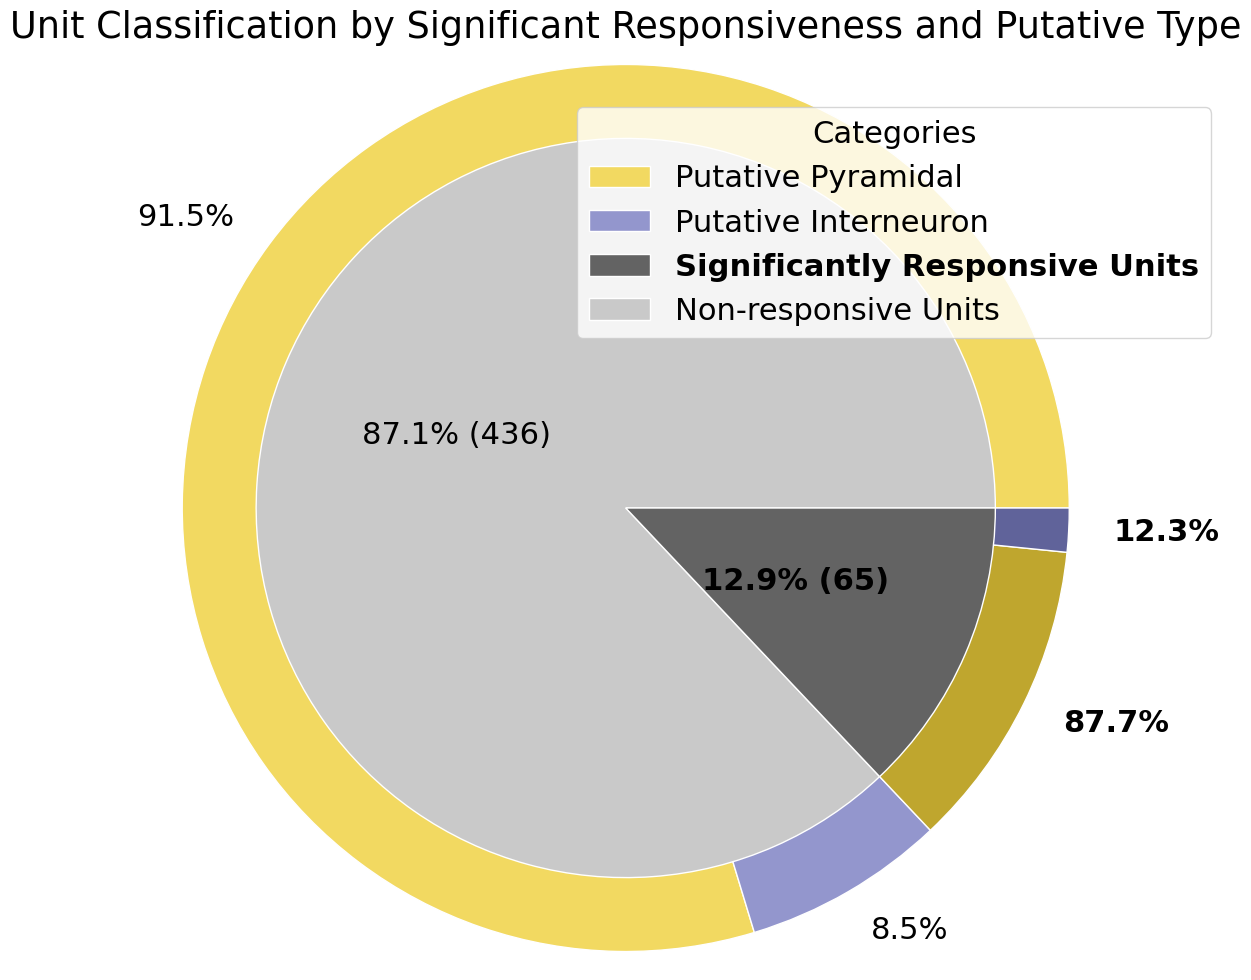

In [13]:
# Assuming units_df is already loaded with your data

# Reclassifying 'exc/inh' for simplification
units_df['exc/inh'] = units_df['sig events'].apply(lambda x: 'Non-Responsive Units' if not x else 'Responsive Units')
units_df['exc/inh'] = units_df['exc/inh'].replace({'excitatory': 'Responsive Units', 'inhibitory': 'Responsive Units', 'both': 'Responsive Units'})

# Prepare data for the outer ring by putative type
responsive_df = units_df[units_df['exc/inh'] == 'Responsive Units']
non_responsive_df = units_df[units_df['exc/inh'] == 'Non-Responsive Units']

putative_responsive_counts = responsive_df['putative type'].value_counts()
putative_non_responsive_counts = non_responsive_df['putative type'].value_counts()

# Colors for the plots
colors_exc_inh = ['#c9c9c9', '#636363']  # Non-Responsive, Responsive
colors_putative = ['#f2d961', '#9396cd', '#bfa62e', '#60639a']  # Updated colors for Pyramidal and Interneuron

# Define a larger figure size to accommodate the legend and increased text size
fig, ax = plt.subplots(figsize=(14, 12))  # Increase the figure size to 14x12 inches

# Set global font size larger
plt.rcParams.update({'font.size': 22})  # Increases the base font size

# Outer ring: Putative type by exc/inh
vals_outer = [
    putative_non_responsive_counts.get('pyramidal', 0), 
    putative_non_responsive_counts.get('interneuron', 0),
    putative_responsive_counts.get('pyramidal', 0), 
    putative_responsive_counts.get('interneuron', 0)
]
percentages_outer = [
    vals_outer[0] / len(non_responsive_df) * 100 if len(non_responsive_df) > 0 else 0,
    vals_outer[1] / len(non_responsive_df) * 100 if len(non_responsive_df) > 0 else 0,
    vals_outer[2] / len(responsive_df) * 100 if len(responsive_df) > 0 else 0,
    vals_outer[3] / len(responsive_df) * 100 if len(responsive_df) > 0 else 0
]
labels_outer = [
    "{:.1f}%".format(percentages_outer[0]),
    "{:.1f}%".format(percentages_outer[1]),
    "{:.1f}%".format(percentages_outer[2]),
    "{:.1f}%".format(percentages_outer[3])
]
wedges_outer, texts_outer = ax.pie(vals_outer, radius=1.2, colors=colors_putative, labels=labels_outer,
       labeldistance=1.1, wedgeprops=dict(width=0.3, edgecolor='w'))

# Bold the appropriate texts for outer responsive units
texts_outer[2].set_fontweight('bold')  # Bold Responsive Pyramidal
texts_outer[3].set_fontweight('bold')  # Bold Responsive Interneuron

# Inner ring: exc/inh
vals_inner = [putative_non_responsive_counts.sum(), putative_responsive_counts.sum()]
wedges_inner, texts_inner, autotexts_inner = ax.pie(vals_inner, radius=1, colors=colors_exc_inh, 
       autopct=lambda pct: "{:.1f}% ({:d})".format(pct, int(pct/100.*np.sum(vals_inner))), pctdistance=0.5, wedgeprops=dict(edgecolor='w'))

# Bold the text for the responsive units in the inner plot
autotexts_inner[1].set_fontweight('bold')  # Bold the percentage and count for responsive units

ax.set(aspect="equal", title='Unit Classification by Significant Responsiveness and Putative Type')

# Adding a simplified legend
legend_labels = ['Putative Pyramidal', 'Putative Interneuron', 'Significantly Responsive Units', 'Non-responsive Units']
legend_wedges = [wedges_outer[0], wedges_outer[1], wedges_inner[1], wedges_inner[0]]

legend = ax.legend(legend_wedges, legend_labels,
          title="Categories",
          loc="upper right",
          bbox_to_anchor=(1.15, 0.95))  # Adjust the location of the legend to avoid overlapping with the title

# Bold the legend text only for "Significantly Responsive Units"
legend.get_texts()[2].set_fontweight('bold')

plt.show()

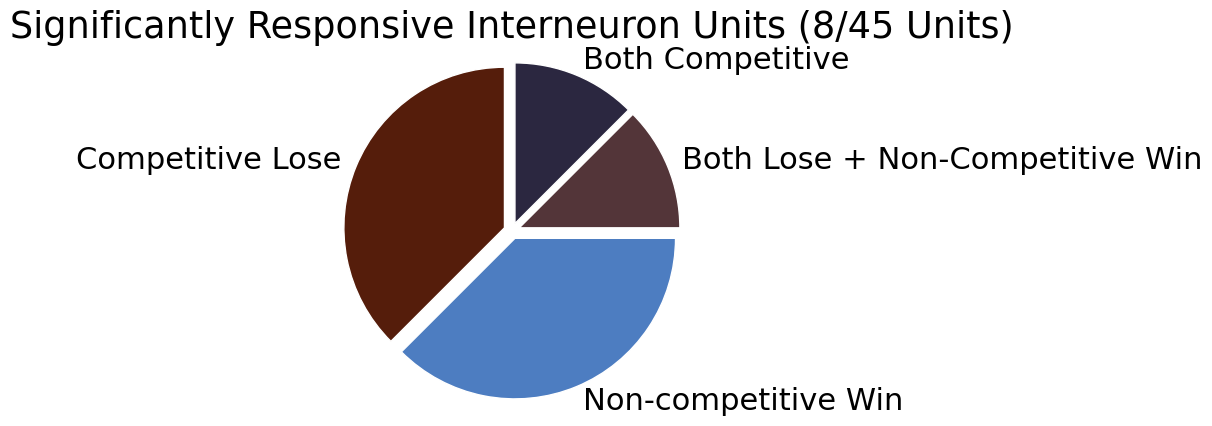

In [14]:
# Provided data breakdown
events_count = {
    '[competitive_lose]': 3,
    '[no_comp_win]': 3,
    '[competitive_lose, no_comp_lose, no_comp_win]': 1,
    '[competitive_lose, competitive_win]': 1
}

# Mapping categories to colors and labels
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b', 'label': 'Competitive Lose'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1', 'label': 'Non-competitive Win'},
    'Both Lose + Non-Competitive Win': {'count': events_count['[competitive_lose, no_comp_lose, no_comp_win]'], 'color': '#533539', 'label': 'Both Lose + Non-Competitive Win'},
    'Both Competitive': {'count': events_count['[competitive_lose, competitive_win]'], 'color': '#2B2740', 'label': 'Both Competitive'}
}

# Prepare data for the pie plot
labels = [category['label'] for category in categories.values()]
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Option to explode slices slightly for better visibility
explode = (0.05, 0.05, 0.05, 0.05)  # slight explosion for each slice

# Create pie plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, startangle=90, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 1})

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Significantly Responsive Interneuron Units (8/45 Units)')

# Check if the directory exists, and if not, create it
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save plot as SVG and JPG
plt.savefig(f'{directory}/interneuron_units.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{directory}/interneuron_units.jpg', format='jpg', bbox_inches='tight')

# Show plot
plt.show()

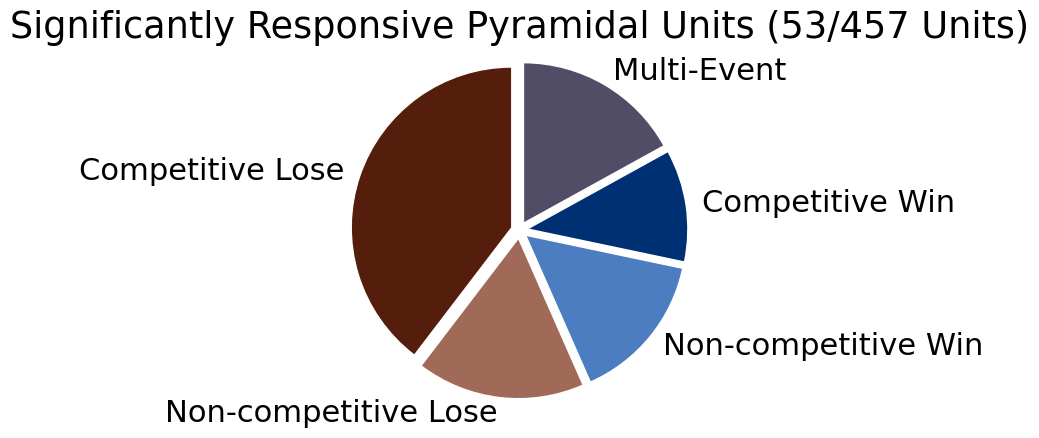

In [15]:
# Data from 'sig events'
events_count = {
    '[]': 404,
    '[competitive_lose]': 21,
    '[no_comp_lose]': 9,
    '[no_comp_win]': 8,
    '[competitive_win]': 6,
    '[competitive_lose, no_comp_win]': 5,
    '[competitive_lose, competitive_win, no_comp_win]': 1,
    '[competitive_win, no_comp_win]': 1,
    '[competitive_lose, no_comp_lose, no_comp_win]': 1,
    '[competitive_win, no_comp_lose]': 1
}

# Categories and their colors
categories = {
    'Competitive Lose': {'count': events_count['[competitive_lose]'], 'color': '#551d0b'},
    'Non-competitive Lose': {'count': events_count['[no_comp_lose]'], 'color': '#a16958'},
    'Non-competitive Win': {'count': events_count['[no_comp_win]'], 'color': '#4d7dc1'},
    'Competitive Win': {'count': events_count['[competitive_win]'], 'color': '#003074'},
    'Multi-Event': {'count': sum([events_count[event] for event in events_count if event not in 
                                 ['[]', '[competitive_lose]', '[no_comp_lose]', '[no_comp_win]', '[competitive_win]']]),
                    'color': '#514D67'}
}

# Prepare data for the pie plot
labels = list(categories.keys())
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]

# Option to explode slices slightly for better visibility
explode = (0.05, 0.05, 0.05, 0.05, 0.05)  # slight explosion for each slice

# Create pie plot
fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, labels=labels, colors=colors, startangle=90, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 1})

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Significantly Responsive Pyramidal Units (53/457 Units)')

# Check if the directory exists, and if not, create it
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)

# Save plot as SVG and JPG
plt.savefig(f'{directory}/pyramidal_units.svg', format='svg', bbox_inches='tight')
plt.savefig(f'{directory}/pyramidal_units.jpg', format='jpg', bbox_inches='tight')

# Show plot
plt.show()

# Above was the Win/Lose Competitive/Non-Competitive
# Below is Win/Lose/Alone_Rewarded

In [16]:
cols = ['condition', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('combined_excel_file.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

In [17]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 250, ignore_freq = 0.5)

All set to analyze


In [18]:
event_and_pre_event_spikes_df = spike_analysis.generate_event_dataframe()

In [19]:
event_and_pre_event_spikes_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,65,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,65,0.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,2,68,0.0,0.0,0.0,12.0,4.0,4.0,...,4.0,0.0,4.0,0.0,4.0,4.0,12.0,8.0,16.0,12.0
16476,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,1,4,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16477,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,2,4,0.0,0.0,0.0,4.0,4.0,0.0,...,0.0,0.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0
16478,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,tie,1,24,12.0,0.0,0.0,4.0,0.0,0.0,...,0.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
event_and_pre_event_spikes_df['Event name'].value_counts()

Event name
win              4976
lose             4915
rewarded         4349
both_rewarded    1816
omission          287
tie               137
Name: count, dtype: int64

In [21]:
win_lose_reward_df = event_and_pre_event_spikes_df[
    (event_and_pre_event_spikes_df['Event name'] == 'win') |
    (event_and_pre_event_spikes_df['Event name'] == 'lose') |
    (event_and_pre_event_spikes_df['Event name'] == 'rewarded')
]

In [22]:
win_lose_reward_df

,Recording,Event name,Event number,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,rewarded,1,65,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20230612_101430_standard_comp_to_training_D1_s...,rewarded,2,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20230612_101430_standard_comp_to_training_D1_s...,rewarded,3,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20230612_101430_standard_comp_to_training_D1_s...,rewarded,4,65,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
4,20230612_101430_standard_comp_to_training_D1_s...,rewarded,5,65,0.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16453,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,lose,6,24,12.0,8.0,8.0,12.0,12.0,20.0,...,8.0,12.0,8.0,0.0,8.0,4.0,0.0,8.0,8.0,4.0
16454,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,lose,7,24,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,8.0,4.0,4.0,4.0,0.0,0.0,4.0,4.0
16455,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,lose,8,24,4.0,4.0,12.0,0.0,4.0,4.0,...,12.0,16.0,8.0,12.0,8.0,16.0,4.0,8.0,8.0,12.0
16456,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,lose,9,24,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,4.0,4.0,0.0,8.0,4.0,4.0,4.0,0.0,8.0


In [23]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
timebin_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col or 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the mean for the timebin columns
event_pre_event_mean_fr = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])[timebin_columns].mean().reset_index()

# Display the new DataFrame
event_pre_event_mean_fr

,Recording,Event name,Unit number,Pre-event timebin 1,Pre-event timebin 2,Pre-event timebin 3,Pre-event timebin 4,Pre-event timebin 5,Pre-event timebin 6,Pre-event timebin 7,...,Event timebin 31,Event timebin 32,Event timebin 33,Event timebin 34,Event timebin 35,Event timebin 36,Event timebin 37,Event timebin 38,Event timebin 39,Event timebin 40
0,20230612_101430_standard_comp_to_training_D1_s...,lose,5,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000
1,20230612_101430_standard_comp_to_training_D1_s...,lose,10,0.571429,0.000000,0.571429,0.571429,1.142857,1.142857,1.714286,...,0.571429,0.000000,0.000000,0.000000,1.142857,0.000000,0.000000,0.000000,0.571429,0.571429
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,1.714286,1.714286,1.714286,4.571429,4.571429,6.285714,1.714286,...,5.714286,2.857143,5.142857,6.285714,3.428571,5.142857,4.000000,3.428571,3.428571,2.857143
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,...,0.000000,0.000000,0.571429,0.571429,0.000000,2.285714,0.571429,0.000000,2.285714,0.571429
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,2.285714,0.571429,4.000000,1.714286,1.142857,3.428571,4.000000,...,2.857143,2.285714,0.571429,1.714286,2.285714,2.285714,1.142857,0.571429,0.571429,1.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,9.714286,8.571429,5.714286,5.714286,8.000000,3.428571,8.000000,...,5.714286,5.714286,5.714286,2.285714,5.142857,10.285714,8.571429,6.857143,10.285714,12.571429
1411,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,4.000000,6.285714,5.142857,2.857143,7.428571,8.000000,8.000000,...,8.000000,6.857143,5.714286,4.571429,8.571429,9.142857,7.428571,8.000000,7.428571,8.000000
1412,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,6.857143,5.142857,8.000000,4.000000,4.571429,4.571429,4.000000,...,4.000000,5.142857,5.714286,5.142857,5.142857,4.571429,6.857143,10.285714,5.714286,6.285714
1413,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,0.000000,0.000000,1.142857,0.571429,0.000000,0.000000,1.142857,...,0.571429,0.000000,0.000000,1.142857,5.142857,1.142857,0.571429,0.571429,3.428571,0.000000


In [24]:
# Identify the columns to be averaged (all columns starting with 'Pre-event timebin' and 'Event timebin')
pre_event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Pre-event timebin' in col]
event_columns = [col for col in event_and_pre_event_spikes_df.columns if 'Event timebin' in col]

# Group by 'Recording', 'Event name', 'Unit number' and compute the required statistics
grouped_df = event_and_pre_event_spikes_df.groupby(['Recording', 'Event name', 'Unit number'])

# Calculate the mean and standard deviation for Pre-event timebin columns
pre_event_means = grouped_df[pre_event_columns].mean().mean(axis=1)
pre_event_sds = grouped_df[pre_event_columns].mean().std(axis=1)

# Calculate the mean for Event timebin columns
event_means = grouped_df[event_columns].mean().mean(axis=1)

# Calculate the Z-score for the Event mean
z_scores = (event_means - pre_event_means) / pre_event_sds

# Create the new DataFrame with the required columns
event_zscores_df = pd.DataFrame({
    'Recording': pre_event_means.index.get_level_values('Recording'),
    'Event name': pre_event_means.index.get_level_values('Event name'),
    'Unit number': pre_event_means.index.get_level_values('Unit number'),
    'Pre-event M': pre_event_means.values,
    'Pre-event SD': pre_event_sds.values,
    'Event M': event_means.values,
    'Event Z-Score': z_scores.values
})

# Reset the index to have a clean DataFrame
event_zscores_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score
0,20230612_101430_standard_comp_to_training_D1_s...,lose,5,0.100000,0.255141,0.071429,-0.111983
1,20230612_101430_standard_comp_to_training_D1_s...,lose,10,0.814286,0.895480,0.642857,-0.191438
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,3.714286,1.446771,3.628571,-0.059245
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.185714,0.374767,0.571429,1.029212
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,1.642857,1.036740,2.014286,0.358266
...,...,...,...,...,...,...,...
1410,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.185714,1.927574,7.328571,0.592899
1411,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,5.414286,2.214977,6.157143,0.335379
1412,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,5.328571,1.592171,5.257143,-0.044862
1413,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,1.314286,1.036841,0.614286,-0.675128


In [25]:
# Define the conditions and corresponding values
conditions = [
    (event_zscores_df['Event Z-Score'] > 1.65),
    (event_zscores_df['Event Z-Score'] < -1.65)]

values = ['increase', 'decrease']

# Apply the conditions
event_zscores_df['sig'] = np.select(conditions, values, default='not sig')

# Display the new DataFrame
event_zscores_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig
0,20230612_101430_standard_comp_to_training_D1_s...,lose,5,0.100000,0.255141,0.071429,-0.111983,not sig
1,20230612_101430_standard_comp_to_training_D1_s...,lose,10,0.814286,0.895480,0.642857,-0.191438,not sig
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,3.714286,1.446771,3.628571,-0.059245,not sig
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.185714,0.374767,0.571429,1.029212,not sig
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,1.642857,1.036740,2.014286,0.358266,not sig
...,...,...,...,...,...,...,...,...
1410,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.185714,1.927574,7.328571,0.592899,not sig
1411,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,5.414286,2.214977,6.157143,0.335379,not sig
1412,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,5.328571,1.592171,5.257143,-0.044862,not sig
1413,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,1.314286,1.036841,0.614286,-0.675128,not sig


In [26]:
# Load the umap_df_detail.pkl file
umap_df_detail = pd.read_pickle('Newest_UMAP/umap_df_detail.pkl')

# Merge event_zscores_df with umap_df_detail based on 'Recording' and 'Unit number'
merged_df = event_zscores_df.merge(
    umap_df_detail[['recording_name', 'unit_id', 'cluster_id']],  # Only select necessary columns
    how='left',
    left_on=['Recording', 'Unit number'],
    right_on=['recording_name', 'unit_id']
)

# Create the 'putative type' column based on the 'cluster_id'
merged_df['putative type'] = merged_df['cluster_id'].apply(lambda x: 'interneuron' if x == 5 else 'pyramidal')

# Drop the unnecessary columns
merged_df = merged_df.drop(columns=['recording_name', 'unit_id', 'cluster_id'])

merged_df

,Recording,Event name,Unit number,Pre-event M,Pre-event SD,Event M,Event Z-Score,sig,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,lose,5,0.100000,0.255141,0.071429,-0.111983,not sig,pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,lose,10,0.814286,0.895480,0.642857,-0.191438,not sig,pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,lose,13,3.714286,1.446771,3.628571,-0.059245,not sig,interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,lose,17,0.185714,0.374767,0.571429,1.029212,not sig,pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,lose,19,1.642857,1.036740,2.014286,0.358266,not sig,pyramidal
...,...,...,...,...,...,...,...,...,...
1410,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,49,6.185714,1.927574,7.328571,0.592899,not sig,pyramidal
1411,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,54,5.414286,2.214977,6.157143,0.335379,not sig,pyramidal
1412,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,68,5.328571,1.592171,5.257143,-0.044862,not sig,pyramidal
1413,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,win,75,1.314286,1.036841,0.614286,-0.675128,not sig,pyramidal


In [27]:
merged_df_win_lose = merged_df[merged_df['Event name'] != 'tie']
merged_df_win_lose = merged_df_win_lose[merged_df_win_lose['Event name'] != 'rewarded']
merged_df_win_lose = merged_df_win_lose[merged_df_win_lose['Event name'] != 'both_rewarded']
merged_df_win_lose = merged_df_win_lose[merged_df_win_lose['Event name'] != 'omission']

## merged_df contains lots of events, right now I'm just looking at win and lose with merged_df_win_lose

In [28]:
# Group by 'Recording' and 'Unit number' and aggregate the required columns
grouped = merged_df_win_lose.groupby(['Recording', 'Unit number']).agg({
    'Event name': lambda x: list(x),
    'sig': lambda x: list(x),
    'putative type': 'first'  # Assuming 'putative type' is consistent within each group
}).reset_index()

# Initialize lists to store the 'sig events' and 'not sig events'
sig_events = []
not_sig_events = []

# Iterate over the grouped DataFrame to populate the lists
for index, row in grouped.iterrows():
    sig_list = []
    not_sig_list = []
    for event_name, sig in zip(row['Event name'], row['sig']):
        if sig != 'not sig':
            sig_list.append(event_name)
        else:
            not_sig_list.append(event_name)
    sig_events.append(sig_list)
    not_sig_events.append(not_sig_list)

# Create the final DataFrame
units_df = pd.DataFrame({
    'Recording': grouped['Recording'],
    'Unit number': grouped['Unit number'],
    'sig events': sig_events,
    'not sig events': not_sig_events,
    'putative type': grouped['putative type']
})

# Display the new DataFrame
units_df

,Recording,Unit number,sig events,not sig events,putative type
0,20230612_101430_standard_comp_to_training_D1_s...,5,[],"[lose, win]",pyramidal
1,20230612_101430_standard_comp_to_training_D1_s...,10,[],"[lose, win]",pyramidal
2,20230612_101430_standard_comp_to_training_D1_s...,13,[],"[lose, win]",interneuron
3,20230612_101430_standard_comp_to_training_D1_s...,17,[],"[lose, win]",pyramidal
4,20230612_101430_standard_comp_to_training_D1_s...,19,[],"[lose, win]",pyramidal
...,...,...,...,...,...
497,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,49,[],"[lose, win]",pyramidal
498,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,54,[],"[lose, win]",pyramidal
499,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,68,[],"[lose, win]",pyramidal
500,20240323_165815_alone_comp_subj_4-2_t5b5_merge...,75,[lose],[win],pyramidal


In [29]:
events_count = units_df['sig events'].value_counts()

In [30]:
events_count

sig events
[]             458
[lose]          18
[win]           17
[lose, win]      9
Name: count, dtype: int64

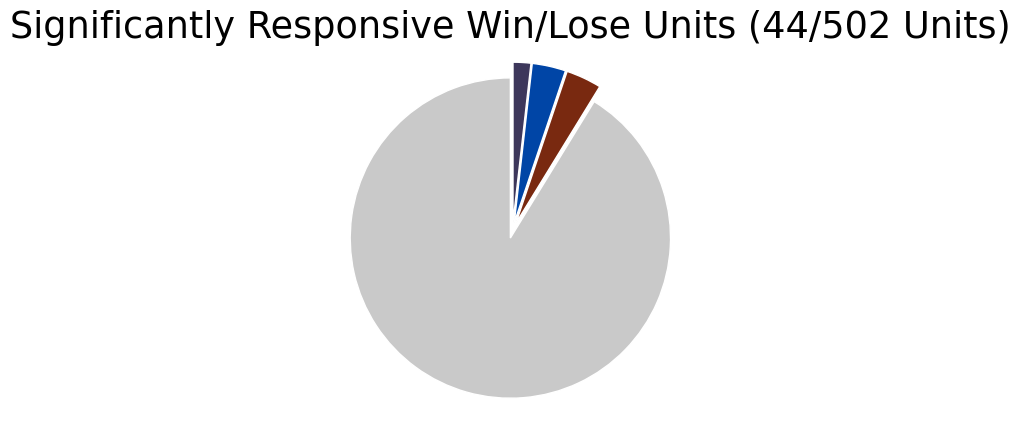

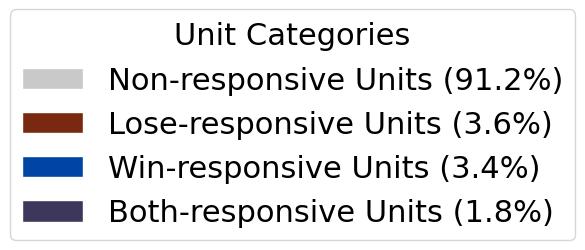

In [31]:
# Provided data breakdown
events_count = {
    "[]": 458,
    "[lose]": 18,
    "[win]": 17,
    "[lose, win]": 9
}

# Mapping categories to colors and labels
categories = {
    'Non-responsive Units': {'count': events_count['[]'], 'color': '#c9c9c9', 'label': 'Non-responsive Units'},
    'Lose-responsive Units': {'count': events_count['[lose]'], 'color': '#792910', 'label': 'Lose-responsive Units'},
    'Win-responsive Units': {'count': events_count['[win]'], 'color': '#0045a6', 'label': 'Win-responsive Units'},
    'Both-responsive Units': {'count': events_count['[lose, win]'], 'color': '#3D375B', 'label': 'Both-responsive Units'}
}

# Prepare data for the pie plot
sizes = [category['count'] for category in categories.values()]
colors = [category['color'] for category in categories.values()]
labels = [f"{category['label']} ({size / sum(sizes) * 100:.1f}%)" for category, size in zip(categories.values(), sizes)]

# Option to explode slices slightly for better visibility
explode = (0.05, 0.05, 0.05, 0.05)  # slight explosion for each slice

# Create pie plot without labels
fig, ax = plt.subplots()
wedges, texts = ax.pie(sizes, colors=colors, startangle=90, explode=explode, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title
plt.title('Significantly Responsive Win/Lose Units (44/502 Units)')

# Save the pie chart without the legend
directory = "leo_poster"
if not os.path.exists(directory):
    os.makedirs(directory)
fig.savefig(f'{directory}/win_lose_units_no_legend.svg', format='svg', bbox_inches='tight')
fig.savefig(f'{directory}/win_lose_units_no_legend.jpg', format='jpg', bbox_inches='tight')

# Create a separate figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(2, 2))  # Adjust size as needed
ax_legend.legend(wedges, labels, title="Unit Categories", loc="center")
ax_legend.axis('off')  # Turn off axes

# Save the legend as a separate file
fig_legend.savefig(f'{directory}/win_lose_units_legend.svg', format='svg', bbox_inches='tight')
fig_legend.savefig(f'{directory}/win_lose_units_legend.jpg', format='jpg', bbox_inches='tight')

# Show plot
plt.show()